# Graphs II
## The Caffeine Molecule

In this example we want to get a better understanding of how much information is stored in a graph, before we move on to run an actual GNN.<br>
An intuitive application for a graph is a molecule, such as the caffeine molecule<br>
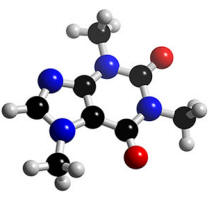
(source: espresso planet)

The atoms are the nodes of the graph. Each node has specific values for their features. The features in this case are<br>
- atomic mass<br>
- electronegativity<br>

The edges of the graph are the molecular bonds, which have different features themselves:<br>
- bond length<br>
- bond strength (affinity)<br>

If we wanted to train a model (see Graph III) on the graph we cloud solve different tasks. One task could be **node classification**, for example predicting the kind of atom based on the location and connections in the molecule. Another task could be **feature prediction**, i. e. predicting the 3D coordinates of each atom within the molecule (i. e. predicting the 3D structure of a protein from an amino acid sequence). That would be a regression problem that could be solved using an embedding (just adding a dense layer after the actual GNN) that represents the 3D structure (see Graph III). The idea is not so different from the problem of word embedding, which we discussed in the previous lecture.<br>
Finally, another task could be **link prediction**. For example, once having a preliminary 3D structure, we could predict new edges within the molecule, which are not direct covalent bonds, but hydrogen bonds, and therefore fine-tune the 3D structure.

<br>

**0) Loading Libraries**

First, we load our standard libraries, plus umap for plotting a UMAP projection

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap #pip install umap-learn
import matplotlib.pyplot as plt

Next, we load a library for displaying a graph

In [45]:
import networkx as nx #pip install networkx

<br>

**1) The Nodes**

First, we implement the nodes, which are the atoms. Caffein is C8-H10-N4-O2. Thus, in order to be able to distinguish the different nodes, we just enumerate the different labels. 

In [47]:
#1a) node labels
Atoms = ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8',\
         'H1', 'H2','H3', 'H4','H5', 'H6','H7', 'H8','H9', 'H10',\
         'N1', 'N2', 'N3', 'N4',\
         'O1', 'O2']

In [49]:
N     = len(Atoms) # needed for later

Next, we create arrays for the features of the nodes to be added later.

In [51]:
Mass = np.array([12,12,12,12,12,12,12,12,\
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1,\
                 14,14,14,14,\
                 16,16])

In [53]:
#electronegativity    
Eminus = np.array([2.55, 2.55, 2.55, 2.55, 2.55, 2.55, 2.55, 2.55,\
                   2.20, 2.20, 2.20, 2.20, 2.20, 2.20, 2.20, 2.20, 2.20, 2.20,\
                   3.04, 3.04, 3.04, 3.04,\
                   3.44, 3.44])

From these features, we can calculate the specific electronegativity (charge/mass) and the difference of those values between each atom. We will use this later for calculating the affinity. 

In [55]:
SpecEminus  = Eminus/Mass
DSpecEminus = np.tile(SpecEminus, (N,1)).transpose() - np.tile(SpecEminus, (N,1))

In [57]:
print(DSpecEminus)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.9875     -1.9875     -1.9875     -1.9875
  -1.9875     -1.9875     -1.9875     -1.9875     -1.9875     -1.9875
  -0.00464286 -0.00464286 -0.00464286 -0.00464286 -0.0025     -0.0025    ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.9875     -1.9875     -1.9875     -1.9875
  -1.9875     -1.9875     -1.9875     -1.9875     -1.9875     -1.9875
  -0.00464286 -0.00464286 -0.00464286 -0.00464286 -0.0025     -0.0025    ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.9875     -1.9875     -1.9875     -1.9875
  -1.9875     -1.9875     -1.9875     -1.9875     -1.9875     -1.9875
  -0.00464286 -0.00464286 -0.00464286 -0.00464286 -0.0025     -0.0025    ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.9875     -1.9875     -1.9875     -1.9875
  -1.9875     -1.9875

<br>

**2) Edges**

Now it is time to generate features for the edges. We start with a matrix *A* that states which atom has covalent bonds with other atoms. A single bond is represented by *1* and a double bond by the number *2*. No bond is represented by the number *0*. 

In [59]:
#             C  C  C  C  C  C  C  C  H  H  H  H  H  H  H  H  H  H  N  N  N  N  O  O
A = np.array((
             [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
             [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0],
             [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
             [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

We can use the matrix *A* for generating the adjacency matrix: 

In [61]:
Adj = np.round((A/(A+1e-16)))

Just using the adjacency matrix would lead to an *unweighted* graph. However, we want to weight the edges according to the binding affinity. This is cruical for understanding the actual structure of the molecule. If we didn't know the affinity, a training task would be calculating the affinity.   

In [63]:
Affinity = A * (DSpecEminus + 1 - np.eye(N)) #np.eye removes diagonal elements 

<br>

**3) Plotting the Molecule**

Let us now see how much information we can derive from the edges and nodes.<br>
In a first step, we just generate a heatmap from the adjacency matrix and see if we can cluster the atoms (nodes) based on that information.

C:\Users\MMH_user\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\MMH_user\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


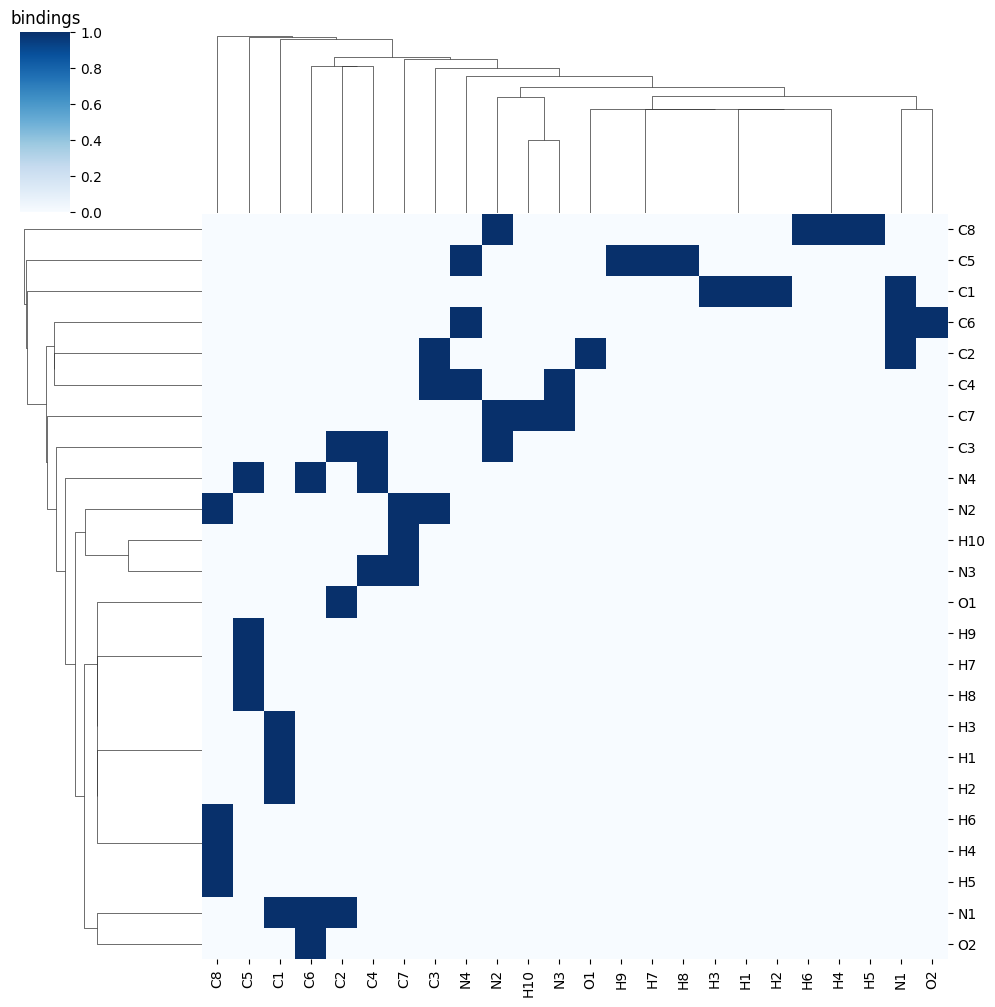

In [65]:
Molecule = pd.DataFrame(Adj, Atoms, Atoms)
sns.clustermap(Molecule, cmap = 'Blues')
plt.title('bindings')
#plt.savefig('Coffeine_tree_Adj.pdf', dpi = 1200)
plt.show()

We can see that a few hydrogen atoms can be grouped together in a cluster, based on their bonds to carbon atoms. We can also try to see if a UMAP plot reassembles the caffeine molecule to some degree, since UMAP is constructing a graph for generating the plot: 

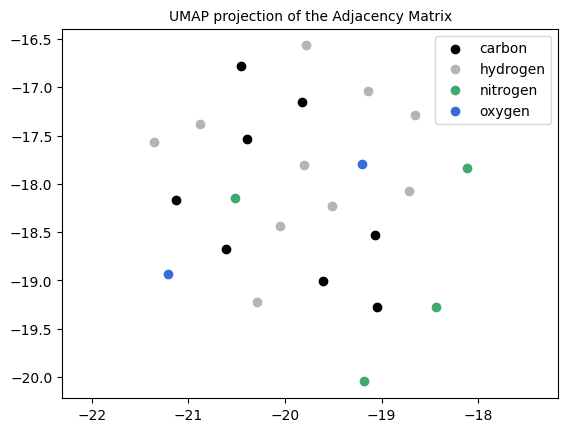

In [67]:
Anew = umap.UMAP().fit_transform(Adj)


plt.scatter(Anew[:8, 0], Anew[:8, 1],       c = 'k',       label = 'carbon')
plt.scatter(Anew[8:18, 0], Anew[8:18, 1],   c = '#b9b3b1', label = 'hydrogen')
plt.scatter(Anew[18:22, 0], Anew[18:22, 1], c = '#42a872', label = 'nitrogen')
plt.scatter(Anew[22:, 0], Anew[22:, 1],     c = '#366ed8', label = 'oxygen')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Adjacency Matrix', fontsize = 10)
plt.legend()
#plt.savefig('Coffeine_UMAP_Adj.pdf', dpi = 1200)
plt.show()

The UMAP plot doesn't reflect the structure of the molecule at all. The reason is that the adjacency matrix does not contain enough information. Let us run the same lines, but this time using the affinity (weighted edges).

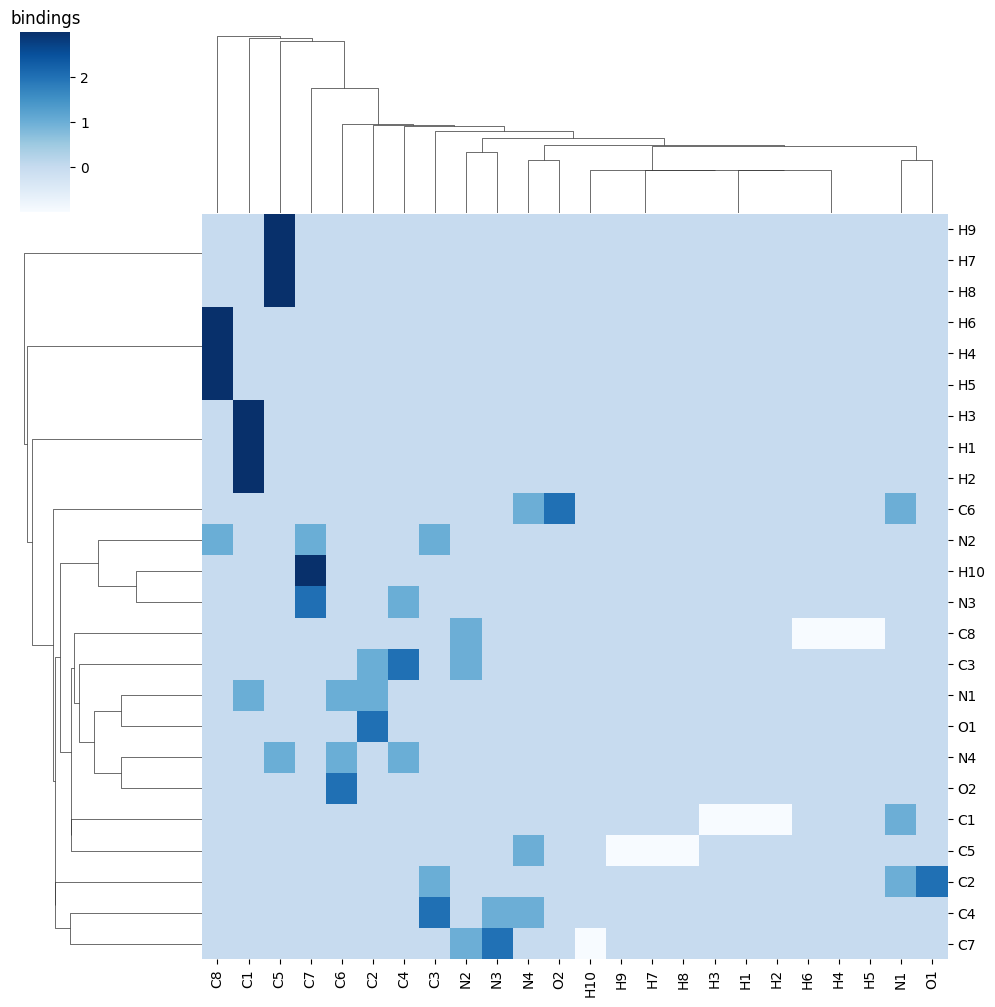

In [69]:
Molecule = pd.DataFrame(Affinity, Atoms, Atoms)
sns.clustermap(Molecule, cmap = 'Blues')
plt.title('bindings')
#plt.savefig('Coffeine_tree_Adj.pdf', dpi = 1200)
plt.show()

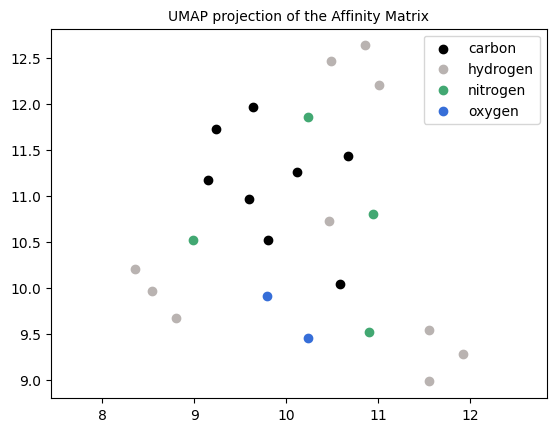

In [73]:
Anew = umap.UMAP().fit_transform(Affinity)

plt.scatter(Anew[:8, 0], Anew[:8, 1],       c = 'k',       label = 'carbon')
plt.scatter(Anew[8:18, 0], Anew[8:18, 1],   c = '#b9b3b1', label = 'hydrogen')
plt.scatter(Anew[18:22, 0], Anew[18:22, 1], c = '#42a872', label = 'nitrogen')
plt.scatter(Anew[22:, 0], Anew[22:, 1],     c = '#366ed8', label = 'oxygen')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Affinity Matrix', fontsize = 10)
plt.legend()
#plt.savefig('Coffeine_UMAP_Aff.pdf', dpi = 1200)
plt.show()

This time we can definitively see some reassembles to the caffeine molecule. The hydrogen atoms are located outside at the molecule, whereas the carbon atoms are located at the inner part. 

<br>

**4) The actual Graph**

The *nx* library needs a certain structure for the node and edge features and for the adjacency. The adjacency matrix has to be converted into an **adjacency tuple**. It essentially lists all connections between the nodes. 

In [75]:
Adj_Tuple = []
Weights   = []#from  Affinity Matrix
Edges     = []

for i in range(N):
    for j in range(N):
        if Adj[i,j] != 0:
            Adj_Tuple += [(Atoms[i], Atoms[j])]
            Weights   += [Affinity[i,j]]
            Edges     += [(i, j)]

Now we construct the graph and add all the properties. Note, that the required format is a *dictionary* for the nodes and *tuples* for the edges.

In [77]:
Caffeine = nx.Graph()
Caffeine.add_nodes_from([(a, {'atom': a, 'atomic mass': m, 'electronegativity': e}) for a, m, e in zip(Atoms, Mass, Eminus)])
Caffeine.add_edges_from(Adj_Tuple)#just the Adjacency Matrix
Caffeine.add_weighted_edges_from( ( (a[0], a[1], w) for a, w in zip(Adj_Tuple, Weights)) )# adding weights

We just want to make sure, that the graph is indeed a weighted graph:

In [79]:
print(nx.is_weighted(Caffeine))

True


And we also pick some random edges in order to make sure that the edge features are set:

In [81]:
Caffeine.get_edge_data('C7', 'N3')

{'weight': 2.0092857142857143}

Finally, we plot the graph and scale the edge length and the edge width to the weights.

C:\Users\MMH_user\AppData\Local\Temp\ipykernel_18980\2840085337.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(Caffeine, pos, edgelist=[edge], width = 2*w)


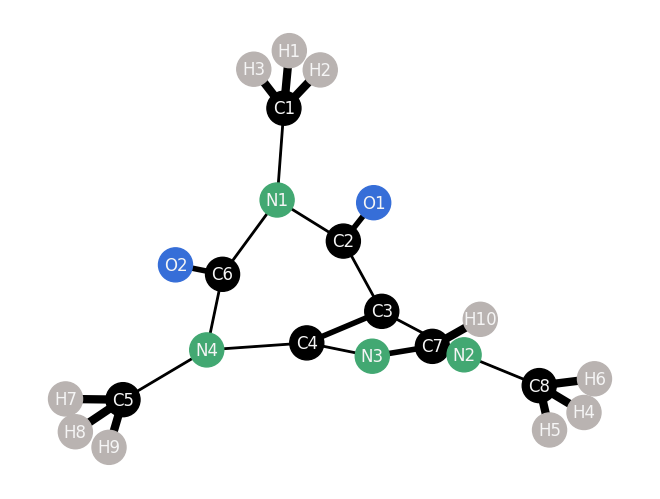

In [85]:
color_map = ['k']*8 + ['#b9b3b1']*10 + ['#42a872']*4 + ['#366ed8']*2

# get node positions for layout, k normalizes spacing between nodes
pos = nx.spring_layout(Caffeine, weight= 'length', k = 0.02)

# draw nodes with labels
nx.draw(Caffeine, pos, with_labels = True, node_color = color_map, font_color = "whitesmoke", node_size = 600)

#draw edge thickness according to weight
for edge in Caffeine.edges(data = 'weight'):
    w = edge[2]
    nx.draw_networkx_edges(Caffeine, pos, edgelist=[edge], width = 2*w)
#plt.savefig('Coffeine.pdf', dpi = 1200)
plt.show()

The result is not bad considering that we haven't trained a model at all and just plotted the graph with the properties as we know them from the periodic table of elements. The next step would be learning the actual 3D structure. However, that requires a suitable training set first. 